In this notebook, we use the MICE method (https://www.statsmodels.org/devel/generated/statsmodels.imputation.mice.MICE.html) to impute missing data in the Enefit training set covering Sept 1, 2021 to May 31, 2023.

Citation:
Kristjan Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). 
Enefit - Predict Energy Behavior of Prosumers. Kaggle. https://kaggle.com/competitions/predict-energy-behavior-of-prosumers

# 1. Missing data

First, we check how much of the data is missing. Below, we see that only the 'target' and '48h_shift' column have missing data.

In [3]:
!pip install fancyimpute

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from fancyimpute import IterativeImputer
from functools import reduce


df = pd.read_csv('/kaggle/input/trainingdata/trainingData.csv') 
df['datetime'] = pd.to_datetime(df['datetime'])

# Data containes 7 columns; 'county', 'is_business', 'is_consumption', and 'product_type', which are categorical, and each determine a time series
# 'target' is the data we want to predict; '48h_shift' is the 48-hour lag. We have to predict 48 hours in advance
# 'datetime' is the date that we need the forecast for


subframe_with_nan = df[df.isna().any(axis=1)]
subframe_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27744 entries, 1993440 to 2021183
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   county          27744 non-null  float64       
 1   is_business     27744 non-null  float64       
 2   is_consumption  27744 non-null  float64       
 3   product_type    27744 non-null  float64       
 4   target          0 non-null      float64       
 5   48h_shift       0 non-null      float64       
 6   datetime        27744 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.7 MB


As seen in the EDA notebook EnefitEDA, the dataframe contains 132 separate timeseries, each of them described by a tuple ('county', 'is_business', 'is_consumption', 'product_type'). Moreover, some of the timeseries are highly correlated; below, we see the correlation values between timeseries with varying county values, and fixed values ('is_business', 'is_consumption', 'product_type') = (0, 1, 0) on the left, and ('is_business', 'is_consumption', 'product_type') = (0, 1, 1) on the right.

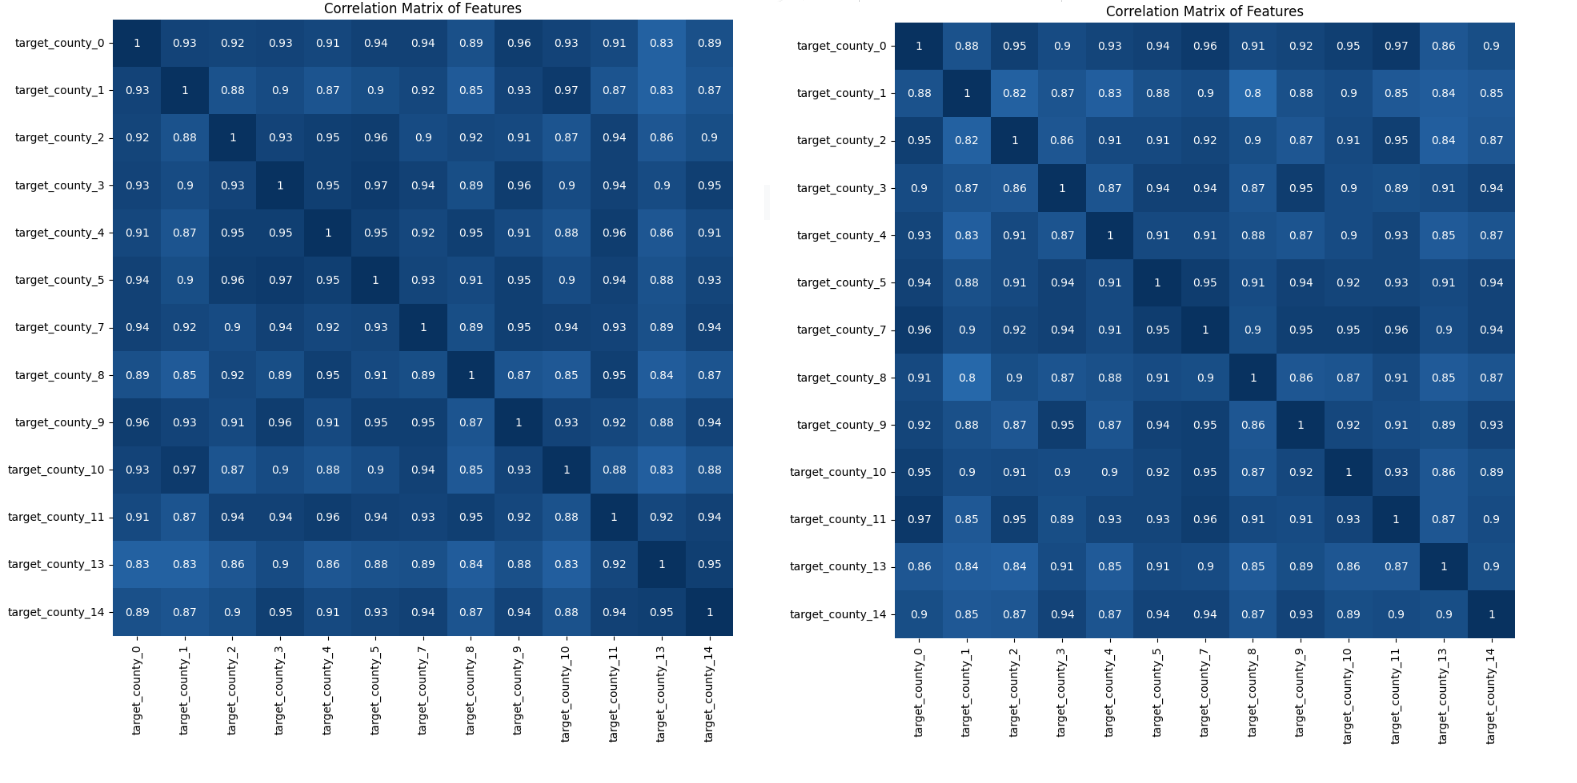


Among the series above, the series with signature (2,0,1,0) and (2,0,1,1) are missing some data, described below:

In [4]:
subframe_2001 = df[(df['county']==2) & (df['is_business']==0) & (df['is_consumption'] == 0) & (df['product_type']==1)]

subframe_2011 = df[(df['county']==2) & (df['is_business']==0) & (df['is_consumption'] == 1) & (df['product_type']==1)]

print(" Signature (2, 0, 0, 1) description is ", subframe_2001.info())
print(" Signature (2, 0, 1, 1) description is ", subframe_2011.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15312 entries, 84980 to 1995599
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   county          15312 non-null  float64       
 1   is_business     15312 non-null  float64       
 2   is_consumption  15312 non-null  float64       
 3   product_type    15312 non-null  float64       
 4   target          14592 non-null  float64       
 5   48h_shift       14592 non-null  float64       
 6   datetime        15312 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 957.0 KB
 Signature (2, 0, 0, 1) description is  None
<class 'pandas.core.frame.DataFrame'>
Index: 15312 entries, 84981 to 1996319
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   county          15312 non-null  float64       
 1   is_business     15312 non-null  float64       


To impute the 'target' data in the first timeseries above, we merge the dataframes with signature (county, 0, 1, 0) for varying county value in one dataframe, then apply MICE.

In [5]:
sign_001=[]
indexed_df=df.set_index('datetime')
is_business_value=0; is_consumption_value=0; product_type_value = 1
for county_value in range(16):
    filtered_df = indexed_df[(indexed_df['county'] == county_value) & (indexed_df['is_business'] == is_business_value) & \
                     (indexed_df['is_consumption'] == is_consumption_value)  & (indexed_df['product_type'] == product_type_value)]['target'].copy()
    filtered_df.rename('target'+'_county_'+str(county_value),  inplace=True)
    if filtered_df.shape[0] !=0:
        sign_001.append(filtered_df)

data   = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), sign_001)
    

In [6]:
data.head()

,target_county_0,target_county_1,target_county_2,target_county_3,target_county_4,target_county_5,target_county_7,target_county_8,target_county_9,target_county_10,target_county_11,target_county_13,target_county_14,target_county_15
datetime,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.713,0.0,NaN,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-01 01:00:00,1.132,0.0,NaN,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-01 02:00:00,0.490,0.0,NaN,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-01 03:00:00,0.496,0.0,NaN,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-01 04:00:00,0.149,0.0,NaN,0.0,0.0,0.479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


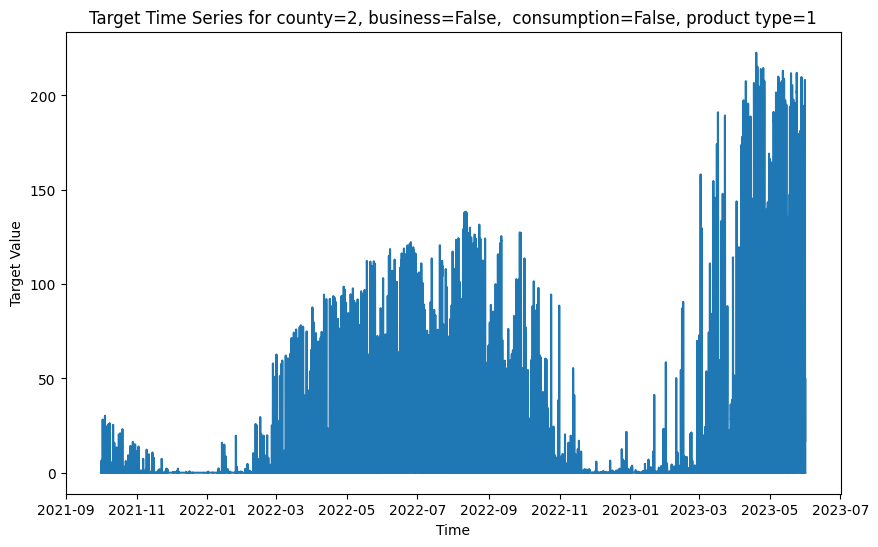

In [7]:

bool_mapping = {0: False, 1: True}

def plot_target(county_value, is_business_value, is_consumption_value, product_type_value, df):
    # Map "is_business' and 'is_consumption' values to True/False
    is_business_value = bool_mapping[is_business_value]
    is_consumption_value = bool_mapping[is_consumption_value]
    
    
    filtered_df = df[(df['county'] == county_value) & (df['is_business'] == is_business_value) & \
                     (df['is_consumption'] == is_consumption_value) & (df['product_type'] == product_type_value)].copy()
    
    filtered_df.set_index('datetime', inplace=True)
    
    if not filtered_df.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_df.index.to_list(), filtered_df['target'].to_list())
        plt.title(f'Target Time Series for county={county_value}, business={is_business_value},  consumption={is_consumption_value}, product type={product_type_value}')
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.show()
    else:
        print(f"No matching data for county={county_value}, is_business={is_business_value},  is_consumption={ is_consumption_value}, product_type={product_type_value}")


imputer = IterativeImputer()

# Fit and transform the DataFrame to impute missing values
imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

plot_target(2, 0, 0, 1, df)


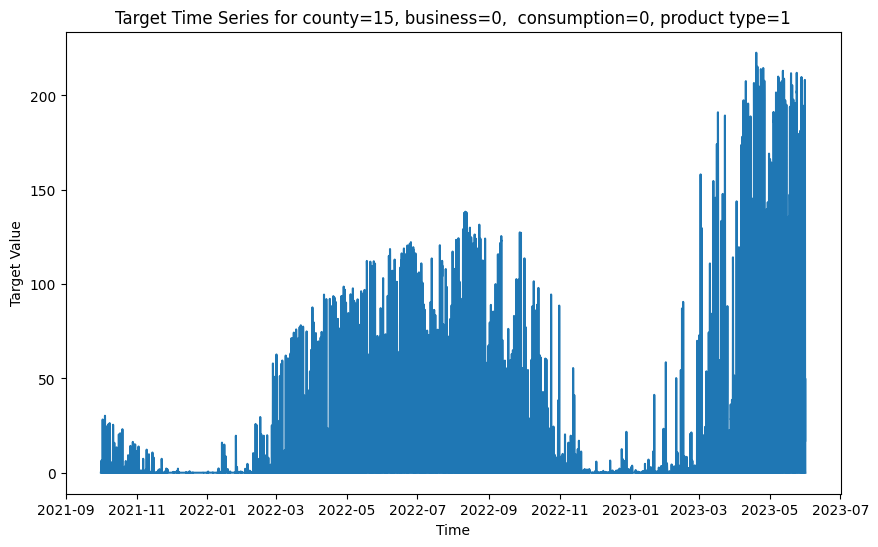

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index.to_list(), data['target_county_2'].to_list())
plt.title(f'Target Time Series for county={county_value}, business={is_business_value},  consumption={is_consumption_value}, product type={product_type_value}')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.show()

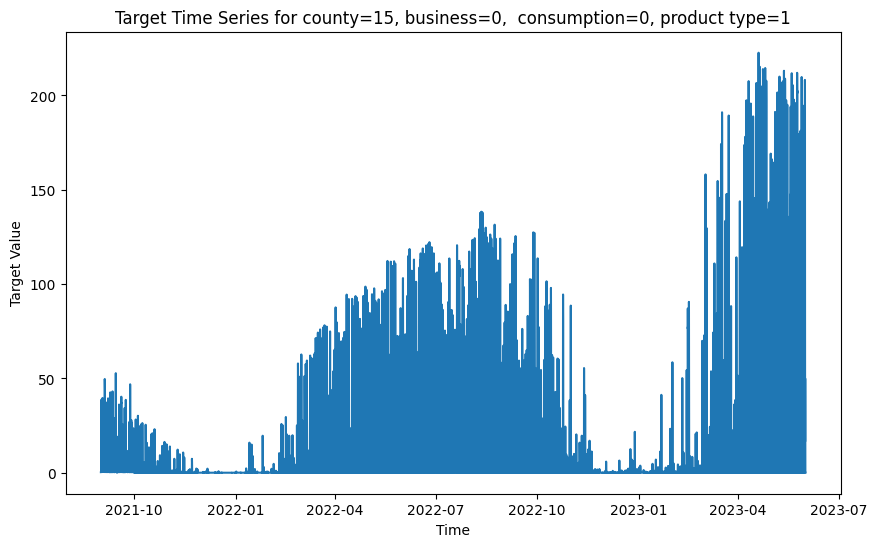

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index.to_list(), imputed_data['target_county_2'].to_list())
plt.title(f'Target Time Series for county={county_value}, business={is_business_value},  consumption={is_consumption_value}, product type={product_type_value}')
plt.xlabel('Time')
plt.ylabel('Target Value')
plt.show()

In [13]:
n_samples = 100

# List to store imputed DataFrames
imputed_dfs = []

# Perform MICE imputation multiple times
for _ in range(n_samples):
    imputer = IterativeImputer()
    imputed_df = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    imputed_dfs.append(imputed_df)

# Calculate confidence intervals for each column
confidence_intervals = {}
for col in data.columns:
    imputed_values = np.vstack([df[col].values.reshape(1, -1) for df in imputed_dfs])
    lower_bound = np.percentile(imputed_values, 2.5, axis=0)
    upper_bound = np.percentile(imputed_values, 97.5, axis=0)
    confidence_intervals[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

# Display confidence intervals
for col, intervals in confidence_intervals.items():
    print(f"{col}:")
    print(f"  Lower Bound: {intervals['lower_bound']}")
    print(f"  Upper Bound: {intervals['upper_bound']}")
    print()

target_county_0:
  Lower Bound: [ 0.713  1.132  0.49  ... 22.428  5.086  2.921]
  Upper Bound: [ 0.713  1.132  0.49  ... 22.428  5.086  2.921]

target_county_1:
  Lower Bound: [0.    0.    0.    ... 3.96  1.311 0.769]
  Upper Bound: [0.    0.    0.    ... 3.96  1.311 0.769]

target_county_2:
  Lower Bound: [0.29321609 0.29985349 0.28968353 ... 0.936      0.         0.        ]
  Upper Bound: [0.29321609 0.29985349 0.28968353 ... 0.936      0.         0.        ]

target_county_3:
  Lower Bound: [0.    0.    0.    ... 2.291 0.086 0.125]
  Upper Bound: [0.    0.    0.    ... 2.291 0.086 0.125]

target_county_4:
  Lower Bound: [0.    0.    0.    ... 0.923 0.082 0.002]
  Upper Bound: [0.    0.    0.    ... 0.923 0.082 0.002]

target_county_5:
  Lower Bound: [0.    0.    0.    ... 4.594 2.175 0.709]
  Upper Bound: [0.    0.    0.    ... 4.594 2.175 0.709]

target_county_7:
  Lower Bound: [0.    0.    0.    ... 4.001 1.034 1.114]
  Upper Bound: [0.    0.    0.    ... 4.001 1.034 1.114]

targ